## Load environment and libraries
This cell loads environment variables from `sample_gemini.env` and imports libraries used later. If you don't have `python-dotenv`, `requests`, `google-generativeai`, or `openai` installed, run the following command in your environment:
```
pip install python-dotenv requests google-generativeai openai
```

In [21]:
from dotenv import load_dotenv
import os
import requests
import json

# Load the env file shipped with this notebook (edit it with your key & model)
load_dotenv('sample_gemini.env')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
GEMINI_MODEL = os.getenv('GEMINI_MODEL', 'text-bison-001')  # Default to free-tier model

print('GEMINI_API_KEY present:', bool(GEMINI_API_KEY))
print('Using model:', GEMINI_MODEL)

GEMINI_API_KEY present: True
Using model: openrouter/sherlock-dash-alpha


## Low-dependency Gemini caller
This cell defines `call_gemini(prompt)` which first tries to use the `google.generativeai` Python package if available and falls back to a simple REST `requests` call to the Generative Language endpoint. The function returns plain text output when possible.

In [ ]:
import json

def call_gemini(prompt, model=GEMINI_MODEL, api_key=GEMINI_API_KEY, max_tokens=512):
    """Call OpenRouter API using openai-python client."""
    if not api_key:
        raise ValueError('GEMINI_API_KEY is not set. Add it to sample_gemini.env')

    from openai import OpenAI

    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=api_key,
    )

    completion = client.chat.completions.create(
        extra_headers={
            "HTTP-Referer": "https://example.com/",  # Optional
            "X-Title": "Example"  # Optional
        },
        extra_body={},
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    )
    return completion.choices[0].message.content

# Example usage
# response = call_gemini("What is Python?")
# print("Response Content:", response)


Response Content: Python is a high-level, interpreted programming language known for its simplicity, readability, and versatility. Created by Guido van Rossum and first released in 1991 (with its latest major version, Python 3, evolving since 2008), it's one of the most popular languages today, used by millions of developers worldwide.

### Key Features
- **Easy to Learn**: Syntax is clean and uses indentation for code blocks (no curly braces), making it beginner-friendly. Example:
  ```python
  # Hello, World!
  print("Hello, World!")
  ```
- **Interpreted and Dynamic**: Runs line-by-line without compilation, with automatic memory management and dynamic typing.
- **Multi-Purpose**: Excels in:
  | Domain          | Examples |
  |-----------------|----------|
  | **Web Development** | Django, Flask |
  | **Data Science/ML** | Pandas, NumPy, TensorFlow, scikit-learn |
  | **Automation/Scripting** | File handling, web scraping (BeautifulSoup, Selenium) |
  | **DevOps/Cloud** | Ansible, Do

## Roadmap generator function
This cell defines `generate_roadmap(topic, level, duration)` which assembles a clear prompt for the model asking for a compact, actionable learning path. The return is the model's plain-text response.

In [ ]:
def generate_roadmap(topic, level='beginner', duration='8 weeks'):
    prompt = f'''You are an expert learning designer.
Create a concise learning roadmap for the topic: {topic}.
Learner level: {level}.
Suggested total duration: {duration}.
Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.
Provide the result as plain text.'''
    return call_gemini(prompt)

## Example usage
Run this cell after you add your API key to `sample_gemini.env`. Change the `topic`, `level`, and `duration` as you like. The notebook will print the model's roadmap output.

In [ ]:
# Example inputs (edit these)
topic = 'Python for Data Science'
level = 'beginner'
duration = '8 weeks'

print('Generating roadmap for:', topic)
roadmap = generate_roadmap(topic, level, duration)
print('\n--- ROADMAP ---\n')
print(roadmap)

## Notes & next steps
- Edit `sample_gemini.env` and set `GEMINI_API_KEY` to your credential and `GEMINI_MODEL` to the model name you want to use (e.g., `gemini-pro-1`).
- Authentication: you can provide either an API key (recommended for quick tests) or an OAuth access token (a short-lived bearer token):
  - API key: create an API key in Google Cloud Console, enable the Generative Language API and billing for your project, then paste the key into `sample_gemini.env`. The notebook will send it as a `?key=` query parameter.
  - OAuth token: if you prefer OAuth, obtain an access token (for example with `gcloud auth application-default print-access-token`) and paste that token into `GEMINI_API_KEY`; the notebook will send it as a Bearer token.
- Common reasons for a 401 error:
  - The Generative Language API is not enabled for the project.
  - Billing is not enabled on the project.
  - You're using the wrong credential type (e.g., pasting a service-account JSON instead of a token or API key).
- If you have `gcloud` installed, you can quickly get an AD token with this command in PowerShell:
```
gcloud auth application-default print-access-token
```
Copy the output and paste it into `sample_gemini.env` as `GEMINI_API_KEY=` (this token expires, so regenerate when needed).
- If you'd like, I can add a small cell to automatically fetch an access token using a service-account JSON or add a parser to structure model output into a DataFrame.

# Step 1: Roadmap Maker Workflow & Node Definitions

This notebook will implement the Roadmap/Learning Path Maker agent step by step. We'll start by defining the workflow and the main nodes:

**Workflow Nodes:**
1. Topic & Goal Selection
2. Background Assessment
3. Roadmap Generation
4. User Review & Feedback
5. Adaptive Branching
6. Final Output

Each node will be implemented as a function or cell, and we'll use a Python dictionary to manage state (user inputs, roadmap versions, feedback, etc.).

Let's begin with the first node: Topic & Goal Selection.

In [4]:
# Node 1: Topic & Goal Selection
# This cell collects the topic and learning goal from the user and stores them in the state dictionary.

state = {}

print("Welcome to the Roadmap/Learning Path Maker!")
topic = input("Enter the topic you want to learn (e.g., Python for Data Science): ")
goal = input("Describe your learning goal (e.g., Get a job, Build a project, Pass a course): ")

state['topic'] = topic
state['goal'] = goal

print(f"Selected Topic: {topic}")
print(f"Learning Goal: {goal}")

Welcome to the Roadmap/Learning Path Maker!
Selected Topic: Python for Data Science
Learning Goal: Build a project
Selected Topic: Python for Data Science
Learning Goal: Build a project


In [5]:
# Node 2: Background Assessment
# This cell collects information about your prior experience, preferred learning style, and available time.

experience = input("Briefly describe your prior experience with this topic (e.g., None, Some basics, Intermediate, Advanced): ")
learning_style = input("Preferred learning style (e.g., Videos, Reading, Projects, Interactive): ")
available_time = input("How much time can you dedicate per week? (e.g., 2 hours, 5 hours, 10 hours): ")

state['experience'] = experience
state['learning_style'] = learning_style
state['available_time'] = available_time

print("\nBackground Assessment Complete:")
print(f"Experience: {experience}")
print(f"Learning Style: {learning_style}")
print(f"Available Time: {available_time}")


Background Assessment Complete:
Experience: Some basics
Learning Style: projects
Available Time: 10


In [ ]:
# Node 3: Roadmap Generation
# This cell uses the collected state to generate a personalized learning roadmap using the LLM.

# Compose a prompt for the LLM based on user inputs
roadmap_prompt = f"""
You are an expert learning designer.
Create a concise, actionable learning roadmap for the topic: {state['topic']}.
Goal: {state['goal']}.
Learner background: {state['experience']}.
Preferred learning style: {state['learning_style']}.
Available time per week: {state['available_time']}.
Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.
Provide the result as plain text.
"""

roadmap = call_gemini(roadmap_prompt)
state['roadmap'] = roadmap

print("\n--- ROADMAP ---\n")
print(roadmap)

In [ ]:
# Node 4: User Review & Feedback
# This cell allows the user to review the generated roadmap and provide feedback for changes.

print("\nPlease review your generated roadmap above.")
feedback = input("Would you like to make any changes? (e.g., add/remove modules, adjust difficulty, change resources) If yes, describe your request. If no, type 'no': ")

state['feedback'] = feedback

if feedback.strip().lower() == 'no':
    print("Roadmap accepted. Proceeding to final output...")
else:
    print(f"Feedback received: {feedback}\nProceeding to adaptive branching...")

In [ ]:
# Node 5: Adaptive Branching
# This cell updates the roadmap based on user feedback, if any, and stores the revised version.

if state['feedback'].strip().lower() == 'no':
    revised_roadmap = state['roadmap']
else:
    # Compose a new prompt for the LLM including the feedback
    adaptive_prompt = f"""
    You are an expert learning designer.
    The user has requested the following changes to their roadmap: {state['feedback']}.
    Please revise the previous roadmap for the topic: {state['topic']}.
    Goal: {state['goal']}.
    Learner background: {state['experience']}.
    Preferred learning style: {state['learning_style']}.
    Available time per week: {state['available_time']}.
    Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.
    Provide the result as plain text.
    """
    revised_roadmap = call_gemini(adaptive_prompt)
    print("\n--- REVISED ROADMAP ---\n")
    print(revised_roadmap)

state['revised_roadmap'] = revised_roadmap

In [ ]:
# Node 6: Final Output
# This cell presents the final roadmap and summarizes user inputs and decisions.

print("\n===== FINAL ROADMAP =====\n")
print(state['revised_roadmap'])

print("\nSummary of your learning path setup:")
print(f"Topic: {state['topic']}")
print(f"Goal: {state['goal']}")
print(f"Experience: {state['experience']}")
print(f"Learning Style: {state['learning_style']}")
print(f"Available Time: {state['available_time']}")
if state['feedback'].strip().lower() == 'no':
    print("No changes requested to the initial roadmap.")
else:
    print(f"Feedback/changes requested: {state['feedback']}")
print("\nThank you for using the Roadmap/Learning Path Maker!")

# LangGraph Integration: Node Definitions

We'll now refactor the workflow to use LangGraph. Each step will be a node function, and the graph will manage state and transitions.

First, ensure you have LangGraph installed:
```
pip install langgraph
```

Next, we'll import LangGraph and define the node functions for each step.

In [ ]:
# Import LangGraph and define node functions
from langgraph.graph import StateGraph
import re

# Define state structure
class RoadmapState:
    def __init__(self):
        self.topic = None
        self.goal = None
        self.experience = None
        self.learning_style = None
        self.available_time = None
        self.roadmap = None
        self.feedback = None
        self.revised_roadmap = None
        self.estimated_level = None
        self.assessment_questions = None
        self.assessment_answers = None
        self.prereqs_needed = None
        self.primer = None
        self.schedule = None
        self.target_duration_weeks = None

# Node 1: Topic & Goal Selection
def node_topic_goal(state: RoadmapState):
    print("Welcome to the Roadmap/Learning Path Maker!")
    state.topic = input("Enter the topic you want to learn (e.g., Python for Data Science): ")
    state.goal = input("Describe your learning goal (e.g., Get a job, Build a project, Pass a course): ")
    return state

# Node 2b: Topic Knowledge Assessment (LLM-generated questions)
def node_topic_assessment(state: RoadmapState):
    # Generate 6 quick assessment questions using the LLM
    prompt = f"""
You are an expert in {state.topic}.
Generate 6 short, practical yes/no questions to quickly assess a learner's knowledge of {state.topic}.
Each question should be phrased as:
Q: [question text]
A. Yes    B. No
Example: Q: Do you know about list comprehensions (e.g., [x for x in range(5)])? A. Yes    B. No
Return only the questions, numbered 1-6, in plain text.
"""
    questions_text = call_gemini(prompt)
    print("\n--- QUICK TOPIC ASSESSMENT ---\n")
    print(questions_text)
    # Parse questions (simple split, assuming numbered list)
    questions = [q.strip() for q in questions_text.split('\n') if q.strip() and q[0].isdigit()]
    answers = []
    for q in questions:
        print(q)
        ans = input("Your answer (A/B): ").strip().upper()
        answers.append(ans)
    # Estimate level: count Yes answers
    yes_count = sum(1 for a in answers if a == 'A')
    if yes_count <= 2:
        level = 'beginner'
    elif yes_count <= 4:
        level = 'intermediate'
    else:
        level = 'advanced'
    print(f"\nEstimated knowledge level: {level} ({yes_count} Yes out of 6)")
    state.assessment_questions = questions
    state.assessment_answers = answers
    state.estimated_level = level
    return state

# Node X: Prerequisite Detection (LLM)
def node_prerequisite_check(state: RoadmapState):
    """Ask the LLM to list prerequisite topics and optionally generate a short primer."""
    prompt = f"""You are an expert instructor for the topic: {state.topic}.
List up to 6 concise prerequisite topics or skills a learner should know before starting {state.topic}.
Return the prerequisites as a numbered list, one item per line."""
    try:
        prereq_text = call_gemini(prompt)
    except Exception as e:
        print('Prerequisite LLM call failed:', e)
        prereq_text = ''
    print('\n--- PREREQUISITES (LLM) ---\n')
    print(prereq_text)
    # Parse numbered lines into a list
    prereqs = [line.strip(" ") for line in prereq_text.split('\n') if line.strip() and re.match(r"^\d+\.?\s+", line)]
    # If no numbered lines, take non-empty lines as fallback
    if not prereqs:
        prereqs = [line.strip() for line in prereq_text.split('\n') if line.strip()]
    state.prereqs_needed = prereqs
    if prereqs:
        wants_primer = input("Would you like a short primer that covers these prerequisites? (yes/no): ").strip().lower()
        if wants_primer in ('yes', 'y'):
            primer_prompt = f"""You are an expert instructor. Create a short primer that covers the following prerequisite topics for {state.topic}: {', '.join(prereqs)}. Keep it concise (around 200-400 words) and present as a short numbered list of quick lessons or reading items."""
            try:
                primer_text = call_gemini(primer_prompt)
            except Exception as e:
                print('Primer generation failed:', e)
                primer_text = ''
            print('\n--- PRIMER ---\n')
            print(primer_text)
            state.primer = primer_text
    else:
        print('No prerequisites identified by the model.')
    return state

# Node 3: Roadmap Generation
def node_generate_roadmap(state: RoadmapState):
    # Build a prompt that includes optional user feedback or primer if present
    feedback_section = ""
    primer_section = ""
    if getattr(state, 'feedback', None) and state.feedback.strip().lower() != 'no':
        feedback_section = f"\nPlease incorporate the following user feedback when revising the roadmap: {state.feedback}\n"
    if getattr(state, 'primer', None):
        primer_section = f"\nThe learner will receive the following primer on prerequisites before starting: {state.primer}\n"
    roadmap_prompt = f"""
You are an expert learning designer.
Create a concise, actionable learning roadmap for the topic: {state.topic}.
Goal: {state.goal}.
Learner background: {state.experience}.
Preferred learning style: {state.learning_style}.
Available time per week: {state.available_time}.
{primer_section}{feedback_section}Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.
Provide the result as plain text.
"""
    state.roadmap = call_gemini(roadmap_prompt)
    print("\n--- ROADMAP ---\n")
    print(state.roadmap)
    return state

# Node 4: User Review & Feedback
def node_review_feedback(state: RoadmapState):
    print("\nPlease review your generated roadmap above.")
    state.feedback = input("Would you like to make any changes? (e.g., add/remove modules, adjust difficulty, change resources) If yes, describe your request. If no, type 'no': ")
    return state

# Node 5: Adaptive Branching (keeps previous behavior as an alternate revision path)
def node_adaptive_branch(state: RoadmapState):
    if state.feedback.strip().lower() == 'no':
        state.revised_roadmap = state.roadmap
    else:
        adaptive_prompt = f"""
You are an expert learning designer.
The user has requested the following changes to their roadmap: {state.feedback}.
Please revise the previous roadmap for the topic: {state.topic}.
Goal: {state.goal}.
Learner background: {state.experience}.
Preferred learning style: {state.learning_style}.
Available time per week: {state.available_time}.
Output a short numbered list of 6-10 modules. For each module include: a one-line goal, suggested resources (URLs or short names), and suggested time. Keep it concise and actionable.
Provide the result as plain text.
"""
        state.revised_roadmap = call_gemini(adaptive_prompt)
        print("\n--- REVISED ROADMAP ---\n")
        print(state.revised_roadmap)
    return state

# Node Y: Schedule & Pacing Builder
def node_schedule_builder(state: RoadmapState):
    """Create a weekly schedule based on modules, available_time, and target duration.

    This version additionally writes a proper iCalendar (.ics) file named `schedule.ics`.
    It will create the .ics locally deterministically, and also offers an optional
    LLM-based formatting fallback (if you choose to use the model to output raw ICS).
    """
    from datetime import datetime, timedelta
    import uuid

    # Parse modules from the roadmap text (attempt numbered list extraction)
    roadmap_text = state.revised_roadmap if getattr(state, 'revised_roadmap', None) else state.roadmap
    modules = []
    if roadmap_text:
        for line in roadmap_text.split('\n'):
            m = re.match(r"^\s*\d+\.?\s*(.+)", line)
            if m:
                modules.append(m.group(1).strip())
        # fallback: split by blank lines and take first N non-empty blocks
        if not modules:
            blocks = [b.strip() for b in roadmap_text.split('\n\n') if b.strip()]
            modules = blocks
    else:
        print('No roadmap available to build schedule from.')
        return state

    # Ask for target duration (weeks)
    try:
        weeks_input = input("Target duration in weeks (press Enter for default 8): ").strip()
        weeks = int(weeks_input) if weeks_input else 8
    except Exception:
        weeks = 8
    state.target_duration_weeks = weeks

    # parse available_time (hours per week)
    try:
        hours_str = str(state.available_time) if state.available_time else ''
        hours = int(re.search(r"(\d+)", hours_str).group(1)) if re.search(r"(\d+)", hours_str) else 5
    except Exception:
        hours = 5

    # Simple distribution: spread modules across weeks as evenly as possible
    schedule = {f'Week {i+1}': [] for i in range(weeks)}
    for idx, mod in enumerate(modules):
        week_idx = (idx * weeks) // max(1, len(modules))
        schedule[f'Week {week_idx+1}'].append(mod)

    # Format schedule text
    schedule_lines = [f"Schedule for topic: {state.topic} (Duration: {weeks} weeks, {hours} hrs/week)\n"]
    for w in range(1, weeks+1):
        key = f'Week {w}'
        mods = schedule.get(key, [])
        schedule_lines.append(f"{key}:")
        if mods:
            for m in mods:
                schedule_lines.append(f"  - {m}")
        else:
            schedule_lines.append("  - (rest/optional review)")
        schedule_lines.append("")
    schedule_text = '\n'.join(schedule_lines)
    state.schedule = schedule_text

    # Save to a simple text file for export
    try:
        with open('schedule.txt', 'w', encoding='utf-8') as f:
            f.write(schedule_text)
        print("Schedule saved to schedule.txt")
    except Exception as e:
        print('Failed to save schedule file:', e)

    print('\n--- GENERATED SCHEDULE ---\n')
    print(schedule_text)

    # Offer .ics export: deterministic local generation + optional LLM formatting
    wants_ics = input("Would you like an iCal (.ics) export created? (yes/no): ").strip().lower()
    if wants_ics in ('yes', 'y'):
        try:
            # Local deterministic ICS creation
            cal_lines = [
                "BEGIN:VCALENDAR",
                "VERSION:2.0",
                "PRODID:-//LangGraph Roadmap//EN",
            ]
            now_utc = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

            # Choose a week-aligned start: Monday of current week
            today = datetime.now()
            monday = today - timedelta(days=today.weekday())

            for wi in range(weeks):
                week_key = f'Week {wi+1}'
                mods = schedule.get(week_key, [])
                for mi, mod in enumerate(mods):
                    # Schedule each module on successive days starting from that week's Monday
                    event_day = monday + timedelta(weeks=wi, days=mi)
                    # Default time: 18:00 local, duration 1 hour
                    event_start = event_day.replace(hour=18, minute=0, second=0, microsecond=0)
                    event_end = event_start + timedelta(hours=1)
                    uid = f"{uuid.uuid4()}@roadmap"
                    cal_lines += [
                        "BEGIN:VEVENT",
                        f"UID:{uid}",
                        f"DTSTAMP:{now_utc}",
                        f"DTSTART:{event_start.strftime('%Y%m%dT%H%M%S')}",
                        f"DTEND:{event_end.strftime('%Y%m%dT%H%M%S')}",
                        f"SUMMARY:{mod}",
                        f"DESCRIPTION:Module for {state.topic}",
                        "END:VEVENT",
                    ]

            cal_lines.append("END:VCALENDAR")
            ical_text = '\n'.join(cal_lines)
            with open('schedule.ics', 'w', encoding='utf-8') as f:
                f.write(ical_text)
            print("iCal export saved to schedule.ics (local generation)")
        except Exception as e:
            print('Local iCal generation failed:', e)

        # Optional: ask the model to produce ICS content (fallback or alternative formatting)
        use_model_ics = input("Also ask the model to output raw .ics content instead of local generation? (yes/no): ").strip().lower()
        if use_model_ics in ('yes', 'y'):
            ics_prompt = f"""You are a helpful assistant. Convert the following human-readable schedule into a valid iCalendar (.ics) file content. Use UTC timestamps where appropriate and create one VEVENT per module. Provide only the raw .ics text (beginning with BEGIN:VCALENDAR).\n\nSchedule:\n{schedule_text}"""
            try:
                ics_response = call_gemini(ics_prompt)
                # If model returned a plausible ICS, save it
                if isinstance(ics_response, str) and 'BEGIN:VCALENDAR' in ics_response:
                    try:
                        with open('schedule.ics', 'w', encoding='utf-8') as f:
                            f.write(ics_response)
                        print('iCal export saved to schedule.ics (model-produced)')
                    except Exception as e:
                        print('Failed to write model-produced .ics file:', e)
                else:
                    print('Model did not return a valid .ics payload; keeping the local .ics if it was created.')
            except Exception as e:
                print('Model ICS generation failed:', e)

    return state

# Node 6: Final Output
def node_final_output(state: RoadmapState):
    print("\n===== FINAL ROADMAP =====\n")
    # If revised_roadmap exists prefer it
    to_print = state.revised_roadmap if getattr(state, 'revised_roadmap', None) else state.roadmap
    print(to_print)
    # Print primer if present
    if getattr(state, 'primer', None):
        print('\n--- PRIMER PROVIDED ---\n')
        print(state.primer)
    # Print schedule if present
    if getattr(state, 'schedule', None):
        print('\n--- SCHEDULE ---\n')
        print(state.schedule)
    print("\nSummary of your learning path setup:")
    print(f"Topic: {state.topic}")
    print(f"Goal: {state.goal}")
    print(f"Experience: {state.experience}")
    print(f"Learning Style: {state.learning_style}")
    print(f"Available Time: {state.available_time}")
    if getattr(state, 'feedback', '').strip().lower() == 'no':
        print("No changes requested to the initial roadmap.")
    else:
        print(f"Feedback/changes requested: {state.feedback}")
    print("\nThank you for using the Roadmap/Learning Path Maker!")
    return state

In [24]:
# Run the Roadmap/Learning Path workflow using node functions (loops back on feedback)
state = RoadmapState()
state = node_topic_goal(state)
state = node_topic_assessment(state)  # Assessment node
state = node_prerequisite_check(state)  # New prerequisite node (inserts primer if requested)

# Loop: generate -> review -> (if feedback != 'no') regenerate incorporating feedback
while True:
    state = node_generate_roadmap(state)
    state = node_review_feedback(state)
    if state.feedback.strip().lower() == 'no':
        # User accepted the roadmap, exit loop
        break
    else:
        print('\nFeedback provided — regenerating roadmap with requested changes...')
        # The next iteration will include state.feedback in the generation prompt
        continue

# Finalize: ensure revised_roadmap reflects the accepted roadmap
state.revised_roadmap = state.roadmap
# Build schedule based on the accepted roadmap
state = node_schedule_builder(state)
# Present final output
state = node_final_output(state)

Welcome to the Roadmap/Learning Path Maker!

--- QUICK TOPIC ASSESSMENT ---

1. Q: Do you know how to use libmicrohttpd to create a basic HTTP server in C?  
A. Yes    B. No

2. Q: Do you know how to parse URL query parameters using CGI in C?  
A. Yes    B. No

3. Q: Do you know how to handle HTTP GET and POST requests with sockets in C?  
A. Yes    B. No

4. Q: Do you know how to generate dynamic HTML responses using printf in C web apps?  
A. Yes    B. No

5. Q: Do you know how to use cURL library for making HTTP requests from C?  
A. Yes    B. No

6. Q: Do you know how to prevent buffer overflows when reading HTTP headers in C?  
A. Yes    B. No
1. Q: Do you know how to use libmicrohttpd to create a basic HTTP server in C?

--- QUICK TOPIC ASSESSMENT ---

1. Q: Do you know how to use libmicrohttpd to create a basic HTTP server in C?  
A. Yes    B. No

2. Q: Do you know how to parse URL query parameters using CGI in C?  
A. Yes    B. No

3. Q: Do you know how to handle HTTP GET and P

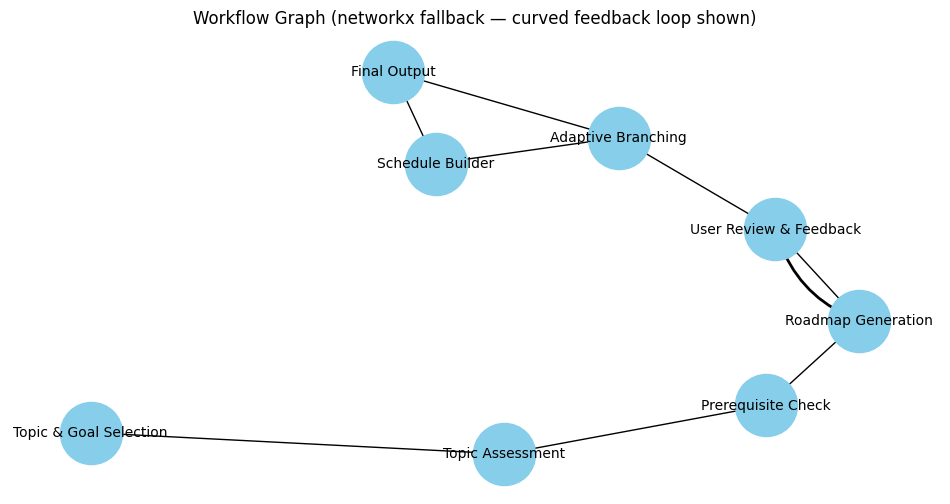

In [26]:
# Visualize the workflow graph using Mermaid (preferred) with networkx fallback
from IPython.display import HTML, display
import matplotlib.pyplot as plt

# Toggle: set True to skip Mermaid and force the networkx fallback (useful if your environment blocks external scripts)
force_networkx = True

# Build the graph edges and nodes in code so both Mermaid and networkx use the same source of truth
edges = [
    ("Topic & Goal Selection", "Topic Assessment"),
    ("Topic Assessment", "Prerequisite Check"),
    ("Prerequisite Check", "Roadmap Generation"),
    ("Roadmap Generation", "User Review & Feedback"),
    ("User Review & Feedback", "Adaptive Branching"),
    ("Adaptive Branching", "Schedule Builder"),
    ("Schedule Builder", "Final Output"),
    ("Adaptive Branching", "Final Output"),
    ("User Review & Feedback", "Roadmap Generation"),  # loop back if user requests changes
]
nodes = []
for a,b in edges:
    if a not in nodes: nodes.append(a)
    if b not in nodes: nodes.append(b)

# Create a simple short-id map for Mermaid node ids
id_map = {name: f"N{i}" for i, name in enumerate(nodes)}
# Build Mermaid flowchart text (left-to-right)
mermaid_lines = []
for a,b in edges:
    mermaid_lines.append(f"{id_map[a]}[\"{a}\"] --> {id_map[b]}[\"{b}\"]")
mermaid_text = "flowchart LR\n" + "\n".join(mermaid_lines)

# Try to render Mermaid using the CDN in the notebook (works in JupyterLab/Notebook viewers that allow external scripts)
mermaid_html = f'''
<script src="https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.min.js"></script>
<div class="mermaid">{mermaid_text}</div>
<script>mermaid.initialize({{startOnLoad:true}});</script>
'''
rendered_mermaid = False
if not force_networkx:
    try:
        display(HTML(mermaid_html))
        rendered_mermaid = True
    except Exception as mer_e:
        print('Mermaid inline rendering failed:', mer_e)
        rendered_mermaid = False

# If inline Mermaid didn't render (or force_networkx is True), fall back to networkx drawing
if force_networkx or not rendered_mermaid:
    try:
        import networkx as nx
    except Exception as e:
        nx = None
        print("Optional dependency 'networkx' not available; install it with pip install networkx for fallback drawing.")
    if nx is not None:
        nxg = nx.DiGraph()
        for n in nodes:
            nxg.add_node(n)
        for a,b in edges:
            nxg.add_edge(a,b)
        pos = nx.spring_layout(nxg)
        plt.figure(figsize=(12,6))
        nx.draw_networkx_nodes(nxg, pos, node_color='skyblue', node_size=2000)
        nx.draw_networkx_labels(nxg, pos, font_size=10)
        # Draw normal edges and curved loop for visibility
        loop_edges = [("User Review & Feedback", "Roadmap Generation")]
        normal_edges = [e for e in nxg.edges() if e not in loop_edges]
        if normal_edges:
            nx.draw_networkx_edges(nxg, pos, edgelist=normal_edges, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.0')
        if loop_edges:
            nx.draw_networkx_edges(nxg, pos, edgelist=loop_edges, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.25', edge_color='black', width=2)
        plt.title('Workflow Graph (networkx fallback — curved feedback loop shown)')
        plt.axis('off')
        plt.show()
    else:
        print('\nWorkflow adjacency list (fallback):')
        for src, dst in edges:
            print(f"{src} -> {dst}")